### Titanic Database

Esta é a lendária competição Titanic ML. A competição é simples: use o aprendizado de máquina para criar um modelo que preveja quais passageiros sobreviveram ao naufrágio do Titanic.

Página da Competição: https://www.kaggle.com/c/titanic

#### Dicionário dos dados

| Variável | Definição | Valores |
| --- | --- | --- |
| survival | Sobreviveu | 0 = No, 1 = Yes |
| pclass | Classe | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sexo	|  |
| Age | Idade (anos) |
| sibsp | Nº de irmãos / cônjuge bordo do Titanic | 	
| parch | Nº de pais/filhos a bordo do Titanic | 	
| ticket | Bilhete | 	
| fare | Tarifa	 | 
| cabin | Número da cabine | 	
| embarked | Porto de embarcação | C = Cherbourg, Q = Queenstown, S = Southampton |

#### Notas das variáveis
**pclass**: um proxy para status socioeconômico (SES)
1st = Supeior
2nd = Médio
3rd = Inferior

**age**: a idade é fracionária se for menor que 1. Se a idade for estimada, ela está na forma de xx.5

**sibsp**: O conjunto de dados define as relações familiares desta forma...
Sibling = irmão, irmã, meio-irmão, meia-irmã
Spouse = marido, esposa (amantes e noivos foram ignorados)

**parch**: O conjunto de dados define as relações familiares dessa maneira...
Parent = mãe, pai
Child = filha, filho, enteada, enteado
Algumas crianças viajavam apenas com uma babá, portanto parch=0 para elas.

### Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

seed_number = 123

In [2]:
main_dir = ''
from google.colab import drive
drive.mount('/content/drive')
main_dir = '/content/drive/MyDrive/Cursos/Machine Learning - NCA/pratica/xgboost/'

Mounted at /content/drive


### Etapa 1: Lendo e entendendo os dados


In [3]:
train = pd.read_csv(f'{main_dir}input/train.csv')
test = pd.read_csv(f'{main_dir}input/test.csv')
train.shape, test.shape

((891, 12), (418, 11))

In [4]:
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

In [5]:
data = pd.concat([train,test],sort=True)
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket'],
      dtype='object')

In [6]:
# Traduzir colunas
data.columns = ['Idade', 'Cabine', 'Embarque', 'Tarifa', 'Nome', 'PaisFilhos',
                'Classe', 'Sexo', 'IrmaosConjuge', 'Sobreviveu', 'Bilhete']

# Traduzir valores
sexo = {'male': 'homem', 'female': 'mulher'}
data['Sexo'] = data['Sexo'].map(sexo)

In [7]:
# Verificar dimensão e colunas
data.shape, data.columns

((1309, 11),
 Index(['Idade', 'Cabine', 'Embarque', 'Tarifa', 'Nome', 'PaisFilhos', 'Classe',
        'Sexo', 'IrmaosConjuge', 'Sobreviveu', 'Bilhete'],
       dtype='object'))

In [8]:
data.head()

,Idade,Cabine,Embarque,Tarifa,Nome,PaisFilhos,Classe,Sexo,IrmaosConjuge,Sobreviveu,Bilhete
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,homem,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,mulher,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,mulher,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,mulher,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,homem,0,0.0,373450


#### Entendendo os dados

In [9]:
# Descrição dos dados numéricos
data.describe()
# Nominal: Sobreviveu
# Ordinal: Classe
# Discreto: PaisFilhos, IrmaosConjuge
# Contínuo: Idade, Tarifa

,Idade,Tarifa,PaisFilhos,Classe,IrmaosConjuge,Sobreviveu
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


In [10]:
# Descrição dos dados categóricos
data.describe(include=['O'])
# Nominal: Sexo, Embarque

,Cabine,Embarque,Nome,Sexo,Bilhete
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Connolly, Miss. Kate",homem,CA. 2343
freq,6,914,2,843,11


### Etapa 2: Limpeza e preparação de dados

In [11]:
# Não é recomendado usar Cabine, Nome e Bilhete
data.drop(['Cabine', 'Nome', 'Bilhete'], axis=1, inplace=True)
data.head()

,Idade,Embarque,Tarifa,PaisFilhos,Classe,Sexo,IrmaosConjuge,Sobreviveu
PassengerId,,,,,,,,
1,22.0,S,7.2500,0,3,homem,1,0.0
2,38.0,C,71.2833,0,1,mulher,1,1.0
3,26.0,S,7.9250,0,3,mulher,0,1.0
4,35.0,S,53.1000,0,1,mulher,1,1.0
5,35.0,S,8.0500,0,3,homem,0,0.0


#### Preenchendo dados incompletos (faltando dados)

In [12]:
data.isnull().sum()

Idade            263
Embarque           2
Tarifa             1
PaisFilhos         0
Classe             0
Sexo               0
IrmaosConjuge      0
Sobreviveu       418
dtype: int64

In [13]:
#Preencher Embarque com Moda
data['Embarque'].fillna(data['Embarque'].mode()[0], inplace=True)

#Preencher Tarifa com Média
data['Tarifa'].fillna(data['Tarifa'].mean(), inplace=True)

#Preencher Idade com Mediana
data['Idade'].fillna(data['Idade'].median(), inplace=True)

data.isnull().sum()

Idade              0
Embarque           0
Tarifa             0
PaisFilhos         0
Classe             0
Sexo               0
IrmaosConjuge      0
Sobreviveu       418
dtype: int64

### Etapa 3: Visualizando os dados
Observar os dados de forma visual para averiguar as suposições feitas até agora


0.0    549
1.0    342
Name: Sobreviveu, dtype: int64
0.0    0.616162
1.0    0.383838
Name: Sobreviveu, dtype: float64


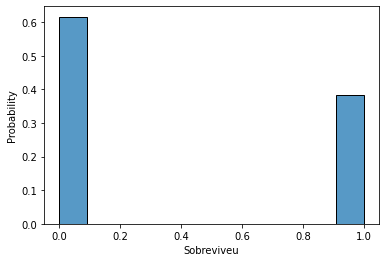

In [14]:
# Sobreviveu - Frequência / Frequência relativa
print(data['Sobreviveu'].value_counts())
print(data['Sobreviveu'].value_counts()/data['Sobreviveu'].count())
sns.histplot(data, x="Sobreviveu", stat="probability")

#### Análise bivariada

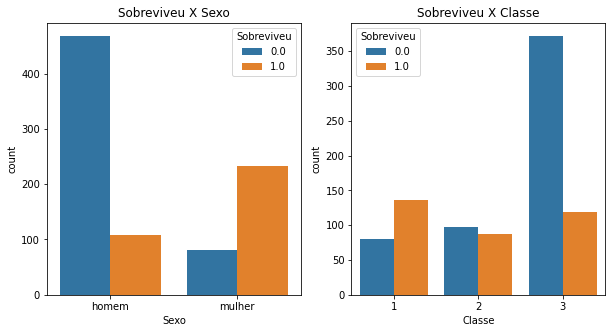

        Sobreviveu
Sexo              
homem          577
mulher         314
        Sobreviveu
Classe            
3              491
1              216
2              184


In [15]:
plt.figure(figsize=(10,5))

# Gráfico de barras (Sexo x Sobreviveu)
plt.subplot(1,2,1)
plt.title('Sobreviveu X Sexo')
sns.countplot('Sexo',hue='Sobreviveu', data=data)

# Gráfico de barras (Classe x Sobreviveu)
plt.subplot(1,2,2)
plt.title('Sobreviveu X Classe')
sns.countplot('Classe',hue='Sobreviveu',data=data)

plt.show();

print(data[['Sexo', 'Sobreviveu']].groupby(['Sexo'])
.count().sort_values(by='Sobreviveu', ascending=False))

print(data[['Classe', 'Sobreviveu']].groupby(['Classe'])
.count().sort_values(by='Sobreviveu', ascending=False))

<a name="barrassob"></a>

### Etapa 5: Variáveis Dummys

In [16]:
data.head()

,Idade,Embarque,Tarifa,PaisFilhos,Classe,Sexo,IrmaosConjuge,Sobreviveu
PassengerId,,,,,,,,
1,22.0,S,7.2500,0,3,homem,1,0.0
2,38.0,C,71.2833,0,1,mulher,1,1.0
3,26.0,S,7.9250,0,3,mulher,0,1.0
4,35.0,S,53.1000,0,1,mulher,1,1.0
5,35.0,S,8.0500,0,3,homem,0,0.0


In [17]:
# Variáveis categóricas

cat_vars = data.select_dtypes(include=['object']).columns.tolist()
num_vars = data.select_dtypes(exclude=['object']).columns.tolist()
cat_vars, num_vars

(['Embarque', 'Sexo'],
 ['Idade', 'Tarifa', 'PaisFilhos', 'Classe', 'IrmaosConjuge', 'Sobreviveu'])

In [18]:
def show_uniques(x,df):
    print(f'{x}: {df[x].unique()}')

for x in cat_vars:
    show_uniques(x,data)

Embarque: ['S' 'C' 'Q']
Sexo: ['homem' 'mulher']


In [19]:
data = pd.get_dummies(data, columns=['Embarque', 'Sexo'], drop_first=True)
data.columns

Index(['Idade', 'Tarifa', 'PaisFilhos', 'Classe', 'IrmaosConjuge',
       'Sobreviveu', 'Embarque_Q', 'Embarque_S', 'Sexo_mulher'],
      dtype='object')

### Etapa 6: Divisão de treino-teste e normalização dos atributos

In [20]:
# Separando os dados do teste (submissão)
test = data.loc[test.index]
test.drop('Sobreviveu', axis=1, inplace=True)


# Separando os dados para treino e validação dos modelos
data = data.loc[train.index]
# data.isnull().sum()
data.shape, test.shape

((891, 9), (418, 8))

In [21]:
#Dividindo dados em variáveis X e y
X = data.drop('Sobreviveu', axis=1)
y = data['Sobreviveu']
X.shape, y.shape

((891, 8), (891,))

#### MODELO 1 - Houdout

In [22]:
from sklearn.model_selection import train_test_split

np.random.seed(seed_number)
# Divisão Holdout 70% treino / 30% teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = seed_number)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 8), (268, 8), (623,), (268,))

In [23]:
from sklearn.preprocessing import MinMaxScaler

features_list = X_train.columns.to_list()

scaler = MinMaxScaler()

X_train[features_list] = scaler.fit_transform(X_train[features_list])
X_test[features_list] = scaler.transform(X_test[features_list])
X_train.describe()

,Idade,Tarifa,PaisFilhos,Classe,IrmaosConjuge,Embarque_Q,Embarque_S,Sexo_mulher
count,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000
mean,0.401489,0.061747,0.073836,0.668539,0.066212,0.080257,0.714286,0.354735
std,0.179791,0.102539,0.158589,0.410480,0.142575,0.271909,0.452117,0.478817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.305752,0.015412,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
50%,0.390762,0.026920,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.475772,0.059113,0.000000,1.000000,0.125000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
import xgboost as xgb

model = xgb.XGBClassifier()

#treinar modelo
model.fit(X_train, y_train)
# gerar predicao
y_pred = model.predict(X_test)


In [25]:
from sklearn.metrics import (recall_score, accuracy_score, precision_score, f1_score, roc_auc_score)

def show_metrics(model, X_test, y_test,y_pred):
    metrics = {
        'recall': recall_score(y_test,y_pred),
        'accuracy': accuracy_score(y_test,y_pred),
        'precision': precision_score(y_test,y_pred),
        'F1': f1_score(y_test,y_pred),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
    print(pd.DataFrame.from_dict(metrics, orient='index',columns=['Metrics']))

show_metrics(model, X_test, y_test, y_pred)


            Metrics
recall     0.640777
accuracy   0.813433
precision  0.835443
F1         0.725275
roc_auc    0.844601


#### MODELO 2 - Validação Cruzada _(Cross-Validation)_

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

folds = 3

kfold = StratifiedKFold(n_splits=folds, shuffle = True, random_state=seed_number)

model = xgb.XGBClassifier(objective="binary:logistic")

In [31]:
X[X.columns] = scaler.fit_transform(X[X.columns])

# cv_result = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc', verbose=0)
cv_result = cross_validate(model, X, y, cv=kfold, scoring=['recall','accuracy', 'precision', 'f1_macro', 'roc_auc'], verbose=0)
cv_result



{'fit_time': array([0.03600001, 0.03480697, 0.03404236]),
 'score_time': array([0.00886893, 0.00854707, 0.00857902]),
 'test_accuracy': array([0.78787879, 0.81481481, 0.82828283]),
 'test_f1_macro': array([0.77216438, 0.79113657, 0.81691707]),
 'test_precision': array([0.74285714, 0.85542169, 0.78899083]),
 'test_recall': array([0.68421053, 0.62280702, 0.75438596]),
 'test_roc_auc': array([0.84529288, 0.86463426, 0.87798389])}

In [32]:
def show_cv_metrics(str, cv_result):
    print('{}: {:.4f} +/- {:.4f}'.format(str, cv_result[str].mean(), cv_result[str].std()))

show_cv_metrics('test_recall', cv_result)
show_cv_metrics('test_accuracy', cv_result)
show_cv_metrics('test_precision', cv_result)
show_cv_metrics('test_f1_macro', cv_result)
show_cv_metrics('test_roc_auc', cv_result)

test_recall: 0.6871 +/- 0.0538
test_accuracy: 0.8103 +/- 0.0168
test_precision: 0.7958 +/- 0.0462
test_f1_macro: 0.7934 +/- 0.0183
test_roc_auc: 0.8626 +/- 0.0134


#### MODELO 3 - Ajuste de hiperparâmetros _(GridSearchCV)_ + Validação Cruzada

Até agora, usamos apenas os hiperparâmetros padrões do Classificador XGBoost. O ajuste dos parâmetros pode resultar em um aumento significativo no desempenho. Vamos dar uma olhada na visão geral dos hiperparâmetros ajustados com mais frequência:

1. **max_depth**: quão profundos podem ir os nós de decisão da árvore. Deve ser um número inteiro positivo.
- valores típicos: 1–10

2. **learning_rate**: também chamado de eta , especifica a rapidez com que o modelo ajusta os erros residuais usando aprendizes de base adicionais.
- valores típicos: 0.01–0.2

3. **gamma, reg_alpha, reg_lambda**: estes 3 parâmetros especificam os valores para 3 tipos de regularização feita pelo XGBoost. 
- valores típicos: gamma: 0 - 0.5; reg_alpha e reg_lambda: 0 - 1

4. **scale_pos_weight**: equilíbrio entre classes positivas e negativas. Recomendado sum(negativas) / sum(positivas).
- valores típico: 1.0

5. **subsample**: fração do conjunto de treinamento que pode ser usada para treinar cada árvore. Se este valor for baixo, pode levar ao underfitting ou se for muito alto, pode levar ao overfitting.
- valores típicos: 0.5–0.9

6. **colsample_bytree**: fração dos atributos que podem ser usados ​​para treinar cada árvore. Um grande valor significa que quase todos os atributos podem ser usados ​​para construir a árvore de decisão.
- valores típicos: 0.5–0.9



In [33]:
# Grade de parâmetros para serem ajustados

# param_grid = {
#     "max_depth": [3, 4, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1, 1.5, 2, 5], 
#     "reg_lambda": [0, 1, 10], 
#     "scale_pos_weight": [1, 2, 3], 
#     "subsample": [0.6, 0.8, 1.0], 
#     "colsample_bytree": [0.5, 0.6, 0.8, 1.0]
# }

from scipy.stats import uniform
from scipy.stats import randint

param_grid = {
    "max_depth":randint(3,7), 
    "learning_rate": uniform(0.01,0.05),
    "gamma": uniform(0, 5),
    "reg_lambda": uniform(0, 10),
    "scale_pos_weight": uniform(1, 5), 
    "subsample": uniform(0.6, 1.0),
    "colsample_bytree": uniform(0.5, 1.0) 
}

In [34]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Inicia o classificador
model = xgb.XGBClassifier(objective="binary:logistic")

# Inicia Grid Search
# grid_cv = GridSearchCV(model, param_grid, cv=folds, scoring="roc_auc", n_jobs=-1)
grid_cv = RandomizedSearchCV(model, param_grid, n_iter=500, cv=folds, scoring="roc_auc", n_jobs=-1, random_state=seed_number)

# Treinamento
_ = grid_cv.fit(X, y)

In [35]:
grid_cv.best_score_

0.8657127792157989

In [36]:
grid_cv.best_params_

{'colsample_bytree': 0.700904395603972,
 'gamma': 2.9359159951037226,
 'learning_rate': 0.021028550855054638,
 'max_depth': 5,
 'reg_lambda': 1.4818921619256187,
 'scale_pos_weight': 2.494902675820597,
 'subsample': 0.8371686363212292}

### Etapa 7: Modelo final e submissão

In [37]:
test.head()

,Idade,Tarifa,PaisFilhos,Classe,IrmaosConjuge,Embarque_Q,Embarque_S,Sexo_mulher
PassengerId,,,,,,,,
892,34.5,7.8292,0,3,0,1,0,0
893,47.0,7.0000,0,3,1,0,1,1
894,62.0,9.6875,0,2,0,1,0,0
895,27.0,8.6625,0,3,0,0,1,0
896,22.0,12.2875,1,3,1,0,1,1


In [38]:
# Pré-processamento
test[features_list] = scaler.transform(test[features_list])

In [39]:
# Treinamento
final_model = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective="binary:logistic"
)

final_model.fit(X,y)

XGBClassifier(colsample_bytree=0.700904395603972, gamma=2.9359159951037226,
              learning_rate=0.021028550855054638, max_depth=5,
              reg_lambda=1.4818921619256187, scale_pos_weight=2.494902675820597,
              subsample=0.8371686363212292)

In [40]:
pred = final_model.predict(test)

#### Submissão

In [41]:
submission = pd.DataFrame({
    'PassengerId': test.index,
    'Survived': pred
})

submission['Survived'] = submission['Survived'].astype('int')

In [42]:
submission.to_csv('submission.csv', index=False)